#### Uninstallio Case Study

This document contains the solution fot the Data Analysis problem given by uninstall.io. and it organized in to below sections:

Customer retention based on their app install-unistall events
Time of the day customers are most active
Purchase value bucket per transaction and customer
week over week revenue trends for purchasing customers
Purchases post installing app
Purchases in 2nd, 3rd…weeks if retention is greater than one week
Is there a steady inflow of revenue for customers with high retention?
Purchasing customers vS Non-purchasing customers behaviour/Activity
Other Actionable insights
Active Users of the App

In [1]:
### Initialize the spark
import findspark
findspark.init()

import pandas as pd
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
import pyspark.sql.functions 
import pyspark.sql.types 
import datetime 
from datetime import date, timedelta, datetime
import time
import os

In [2]:
sc = SparkSession.builder.getOrCreate()

df = sc.sql('''select 'spark' as hello ''')
df.show()

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

+-----+
|hello|
+-----+
|spark|
+-----+



In [3]:
    print("Current Working Directory " , os.getcwd())
    
    
    try:
        # Change the current working Directory    
        os.chdir("C:\\Data Science\\Certifications\\AnalytixLabs\\Big Data-Hadoop-Spark\\Class 19-20 Files\\Spark Case Studies - Assignments\\App Analytics")
        print("Directory changed")
    except OSError:
        print("Can't change the Current Working Directory")        
    print("Current Working Directory " , os.getcwd())
    
    # Check if New path exists
    if os.path.exists("C:\\Data Science\\Certifications\\AnalytixLabs\\Big Data-Hadoop-Spark\\Class 19-20 Files\\Spark Case Studies - Assignments\\App Analytics") :
        # Change the current working Directory    
        os.chdir("C:\\Data Science\\Certifications\\AnalytixLabs\\Big Data-Hadoop-Spark\\Class 19-20 Files\\Spark Case Studies - Assignments\\App Analytics")
    else:
        print("Can't change the Current Working Directory")    
        
    
    print("Current Working Directory " , os.getcwd())

Current Working Directory  C:\Users\SESA475934\PySpark Projects
Directory changed
Current Working Directory  C:\Data Science\Certifications\AnalytixLabs\Big Data-Hadoop-Spark\Class 19-20 Files\Spark Case Studies - Assignments\App Analytics
Current Working Directory  C:\Data Science\Certifications\AnalytixLabs\Big Data-Hadoop-Spark\Class 19-20 Files\Spark Case Studies - Assignments\App Analytics


In [4]:
# Load input files

eventdump = sc.read.csv('C:\\Data Science\\Certifications\\AnalytixLabs\\Big Data-Hadoop-Spark\\Class 19-20 Files\\Spark Case Studies - Assignments\\App Analytics/Data/eventdump.csv', inferSchema=True,header=True)
uicycles = sc.read.csv('C:\\Data Science\\Certifications\\AnalytixLabs\\Big Data-Hadoop-Spark\\Class 19-20 Files\\Spark Case Studies - Assignments\\App Analytics/Data/uicycles.csv', inferSchema=True,header=True)                      

In [5]:
# View 10 records

eventdump.show(10)
uicycles.show(10) 

+----------------+--------------------+---------------+--------------------+
|            uuid|               event|event_timestamp|          properties|
+----------------+--------------------+---------------+--------------------+
|43e1796c34ac2a91|      Cart is viewed|        07:56.9|{'email_id': 'car...|
| 3065bf9960737af|      Cart is viewed|        04:00.1|{'email_id': 'dev...|
|636677073e9445e3|Search results pa...|        26:23.2|{'category': 'Pan...|
|75f156f9584ffccf|Push notification...|        31:20.9|{'timeStamp': '29...|
|651557edb4a564b0| Search is initiated|        12:53.3|{'search_query': ...|
|deb31f2e06e407e3|      Cart is viewed|        41:27.1|{'timeStamp': '29...|
|98b0621b7dbd8c68|      Cart is viewed|        44:21.8|{'email_id': 'par...|
|b0e892b0074e64b3|Push notification...|        07:10.3|{'timeStamp': '29...|
|58a06d3a55470575| Search is initiated|        01:46.3|{'search_query': ...|
|898ffc7c4a07a3f8|      Cart is viewed|        15:31.5|{'email_id': 'rol...|

In [6]:
eventdump.schema
uicycles.schema

StructType(List(StructField(uuid,StringType,true),StructField(os,StringType,true),StructField(event_type,StringType,true),StructField(creation_date,TimestampType,true)))

In [7]:
eventdump.count()
uicycles.count()

161351

In [8]:
eventdump.unpersist()
uicycles.unpersist()

DataFrame[uuid: string, os: string, event_type: string, creation_date: timestamp]

In [9]:
# Let's cache the dataset
eventdump.cache()
eventdump.printSchema()

uicycles.cache()
uicycles.printSchema()

root
 |-- uuid: string (nullable = true)
 |-- event: string (nullable = true)
 |-- event_timestamp: string (nullable = true)
 |-- properties: string (nullable = true)

root
 |-- uuid: string (nullable = true)
 |-- os: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- creation_date: timestamp (nullable = true)



In [10]:
uicycles.describe().show()
eventdump.describe().show()

+-------+----------------+-------+----------+
|summary|            uuid|     os|event_type|
+-------+----------------+-------+----------+
|  count|          161349| 161349|    161351|
|   mean|        Infinity|   null|      null|
| stddev|             NaN|   null|      null|
|    min|085d478f5ec1c379|Android|   install|
|    max|p75307l0fcr5a7u9|Android| uninstall|
+-------+----------------+-------+----------+

+-------+----------------+--------------------+---------------+--------------------+
|summary|            uuid|               event|event_timestamp|          properties|
+-------+----------------+--------------------+---------------+--------------------+
|  count|          995304|              995304|         995304|              995304|
|   mean|        Infinity|                null|           null|                null|
| stddev|             NaN|                null|           null|                null|
|    min|085d478f5ec1c379|Add shipping address|        00:00.0|{'Category':

#### 1. Customer retention trends from their lifetime cycles [frequency chart or histogram plot] [retention is defined as the duration of one install-uninstall cycle, so multiple re-installs have to be treated separately]

In [11]:
# Registering the tables for normal SQL like operations

uicycles.registerTempTable("uicycles")
eventdump.registerTempTable("eventdump")

In [12]:
# Run sample SQL operations

sc.sql("select * from uicycles").show(2)
sc.sql("select * from eventdump").show(2)

+----------------+-------+----------+-------------------+
|            uuid|     os|event_type|      creation_date|
+----------------+-------+----------+-------------------+
|a9ba6d0cd8586a4f|Android|   install|2016-08-06 19:54:47|
|7365ac7d0721bbf0|Android|re-install|2016-08-14 16:04:45|
+----------------+-------+----------+-------------------+
only showing top 2 rows

+----------------+--------------+---------------+--------------------+
|            uuid|         event|event_timestamp|          properties|
+----------------+--------------+---------------+--------------------+
|43e1796c34ac2a91|Cart is viewed|        07:56.9|{'email_id': 'car...|
| 3065bf9960737af|Cart is viewed|        04:00.1|{'email_id': 'dev...|
+----------------+--------------+---------------+--------------------+
only showing top 2 rows



In [13]:
# Aggregate the install-uninstall-reinstall event type for each user

#sc.sql("select uuid,collect_list(event_type) from uicycles group by uuid").show(5)
df1 = sc.sql("select uuid,concat_ws('#', collect_list(event_type)) as event_sequence  from uicycles group by uuid")
df1.show(5)
# register as a table for sql operations
df1.registerTempTable("df1")

+----------------+-----------------+
|            uuid|   event_sequence|
+----------------+-----------------+
| 10001b8438ddec6|install#uninstall|
|1068d33cc43241b8|          install|
|1082f9be747d08c1|          install|
|10921aeecf71f5b3|       re-install|
|10b5393c58872a58|          install|
+----------------+-----------------+
only showing top 5 rows



In [14]:
# Define a new metric-"cycle" for each user. If event_sequence has 1 "install#uninstall" then cycle = 1 and so on

df2 = sc.sql("select uuid,event_sequence,(char_length(event_sequence) - char_length(REPLACE(event_sequence, '#', ''))) / char_length('#') as cycle  from df1 ")
df2.show(5)
df2.registerTempTable("df2")

+----------------+-----------------+-----+
|            uuid|   event_sequence|cycle|
+----------------+-----------------+-----+
| 10001b8438ddec6|install#uninstall|  1.0|
|1068d33cc43241b8|          install|  0.0|
|1082f9be747d08c1|          install|  0.0|
|10921aeecf71f5b3|       re-install|  0.0|
|10b5393c58872a58|          install|  0.0|
+----------------+-----------------+-----+
only showing top 5 rows



In [15]:
# Frequency table of cycle

df2.cube("cycle").count().show()
#sc.sql("select event_sequence from df2 where cycle = 7").show()
#sc.sql("select count(*) from df2").show()

+-----+------+
|cycle| count|
+-----+------+
|  1.0| 39153|
| null|118242|
| 14.0|     1|
| 11.0|     1|
|  2.0|   835|
|  0.0| 77561|
|  4.0|    50|
|  7.0|     9|
|  5.0|    32|
|  9.0|     2|
|  8.0|     1|
|  6.0|     7|
|  3.0|   590|
+-----+------+



Text(0, 0.5, 'Frequency')

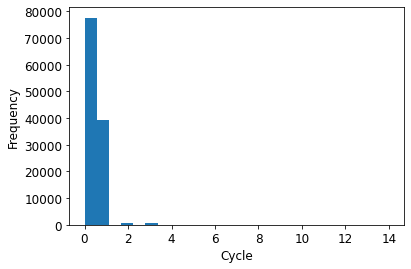

In [16]:
# Frequency Graph(Histogram) of df2
import matplotlib.pyplot as plt
df2_pd = df2.toPandas()

%matplotlib inline
df2_pd['cycle'].hist(bins=25, grid=False, xlabelsize=12, ylabelsize=12)
plt.xlabel("Cycle", fontsize=12)
plt.ylabel("Frequency",fontsize=12)

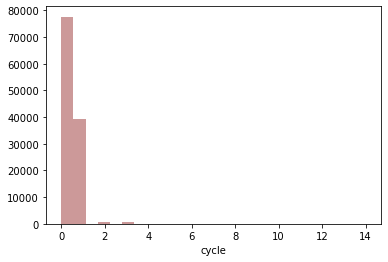

In [17]:
#Histogram using Seaborn

import seaborn as sns
sns.distplot(df2_pd['cycle'], kde=False, color='maroon', bins=25)

#### 2. Find out the time of day when the customers are most active [use your own discretion for time of day bucketing] [activity is defined on the basis of events]

In [18]:
sc.sql("select event_timestamp, count(event) from eventdump group by event_timestamp").show(10)

+---------------+------------+
|event_timestamp|count(event)|
+---------------+------------+
|        21:31.0|          30|
|        47:48.9|          23|
|        33:24.3|          14|
|        25:14.9|          23|
|        01:14.0|          32|
|        52:37.7|          31|
|        46:09.0|          25|
|        57:09.9|          19|
|        34:11.3|          33|
|        32:34.9|          38|
+---------------+------------+
only showing top 10 rows



In [19]:
sc.sql("SELECT  event_timestamp, to_timestamp(event_timestamp, 'HH:mm:ss') as `TIME STAMP DATE` FROM eventdump").show(5)


+---------------+---------------+
|event_timestamp|TIME STAMP DATE|
+---------------+---------------+
|        07:56.9|           null|
|        04:00.1|           null|
|        26:23.2|           null|
|        31:20.9|           null|
|        12:53.3|           null|
+---------------+---------------+
only showing top 5 rows



Text(0, 0.5, 'Frequency')

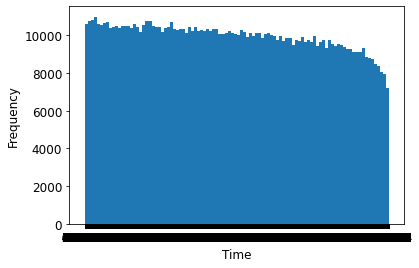

In [20]:
# Frequency Graph(Histogram) of eventdump_pd
import matplotlib.pyplot as plt
eventdump_pd = eventdump.toPandas()

%matplotlib inline
eventdump_pd['event_timestamp'].hist(bins=100, grid=False, xlabelsize=12, ylabelsize=12)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Frequency",fontsize=12)

#### 3.Purchase value buckets [find purchase/checkout events from event logs and parse the 'properties' column to get total value associated and generate a simple bucketed frequency chart/histogram plot]

In [21]:
# Read the csv file into a pyspark dataframe
# Before reading open the file and replace the double double-quotes("") with a single quote(') for the properties column

#eventdump = sc.read.option("header", "true").csv("C:\\Data Science\\Certifications\\AnalytixLabs\\Big Data-Hadoop-Spark\\Class 19-20 Files\\Spark Case Studies - Assignments\\App Analytics\\Data\\eventdump.csv")
eventdump = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true', delimiter=",").load('C:\\Data Science\\Certifications\\AnalytixLabs\\Big Data-Hadoop-Spark\\Class 19-20 Files\\Spark Case Studies - Assignments\\App Analytics\\Data\\eventdump.csv')
eventdump.show(truncate=False)
eventdump.registerTempTable("eventdump")

+----------------+--------------------------+---------------+-------------------------------------------------------------------------------------------------------------------------+
|uuid            |event                     |event_timestamp|properties                                                                                                               |
+----------------+--------------------------+---------------+-------------------------------------------------------------------------------------------------------------------------+
|43e1796c34ac2a91|Cart is viewed            |07:56.9        |{'email_id': 'careers24@gmail.com', 'timeStamp': '29-08-2016 07:43:10', 'No Of Products': 1, 'Cart Value': '1495'}       |
|3065bf9960737af |Cart is viewed            |04:00.1        |{'email_id': 'devangnipathak@gmail.com', 'timeStamp': '29-08-2016 08:39:03', 'No Of Products': 4, 'Cart Value': '877'}   |
|636677073e9445e3|Search results page viewed|26:23.2        |{'category': 'Panti

In [22]:
# Define a pyspark dataframe that will contain the 'properties' column only for purchasing orders

df3 = sc.sql("select properties from eventdump \
             where event in ('Checkout is completed by Cash On Delivery','Checkout is completed by Credit Cards / Debit Cards / Net Banking','Checkout is completed by null','Checkout is completed by Paid using zCoins','Checkout is completed by PG')")
df3.show(df.count(), False) # without truncation
#df3.show(3)
df3.registerTempTable("df3")


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|properties                                                                                                                                                                                                           |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{'orderId': '600731657', 'timeStamp': '25-08-2016 10:28:02', 'ts': '25-08-2016 10:28:02', 'shipping': 0.0, 'discount': 0.0, 'No Of Products': 6, 'payment_mode': 'Cash On Delivery', 'total': 4500, 'subtotal': 4475}|
+---------------------------------------------------------------------------------------------------------------------------------------

In [23]:
# Do all purchasing records have a 'total' column in the properties column ?
# There are 32 records with no total column even though they are purchasing events
# We will exclude such records to avoid error going forward

sc.sql("select distinct(uuid) from eventdump where properties not like '%total%' and event in ('Checkout is completed by Cash On Delivery','Checkout is completed by Credit Cards / Debit Cards / Net Banking','Checkout is completed by null','Checkout is completed by Paid using zCoins','Checkout is completed by PG')").show()

+----------------+
|            uuid|
+----------------+
|5b52b71f5b25f36c|
| d6340f4c6d873b8|
| cf0ee9257168751|
|fc8be70522276c3c|
|d03076a6ed4be916|
|768d79f776f9c213|
|5e4d5d897ad926c4|
|451faebfea0553c4|
|f5acd342a843de65|
|b028e500e5bfa365|
|2de303651886e84a|
|8b8b60f260c26b70|
|9f288a9a3b81e64e|
|7cb7889c14de1258|
|1a12d5803acd21ea|
|9ccd0b2fcd7a23be|
|eedafdfdfac61d2e|
|6072e980c3d54ec0|
|72fdb6dd0d3ffeb9|
|ebb444f84a2a1765|
+----------------+
only showing top 20 rows



In [24]:
# Redefine a pyspark dataframe that will contain the 'properties' column only for purchasing orders
# After excluding those that dont have total column

df3 = sc.sql("select * from eventdump \
             where event in ('Checkout is completed by Cash On Delivery','Checkout is completed by Credit Cards / Debit Cards / Net Banking','Checkout is completed by null','Checkout is completed by Paid using zCoins','Checkout is completed by PG') \
             and properties like '%total%'")
df3.show(df.count(), False) # without truncation
#df3.show(3)
df3.registerTempTable("df3")

+----------------+-----------------------------------------+---------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|uuid            |event                                    |event_timestamp|properties                                                                                                                                                                                                           |
+----------------+-----------------------------------------+---------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|43e1796c34ac2a91|Checkout is completed by Cash On Delivery|52:59.1        |{'orderId': '600731657', 'timeStamp': '25-08-2016 1

In [25]:
# Define a function that will parse the "total" field from the properties column

import json
import sys

def json_total(stg): 
    stg = stg.replace("'", '"') # since json format needs double quotes in the string
    y = json.loads(stg)
#    print(y)
    return(y['total'])

# test with a sample string from properties column
stg = "{'orderId': '600731657', 'timeStamp': '25-08-2016 10:28:02', 'ts': '25-08-2016 10:28:02', 'shipping': 0.0, 'discount': 0.0, 'No Of Products': 6, 'payment_mode': 'Cash On Delivery', 'total': 4500, 'subtotal': 4475}"
#stg = '{"orderId": "600731657", "timeStamp": "25-08-2016 10:28:02", "ts": "25-08-2016 10:28:02", "shipping": 0.0, "discount": 0.0, "No Of Products": 6, "payment_mode": "Cash On Delivery", "total": 4500, "subtotal": 4475}'
json_total(stg) 

4500

In [26]:
# Convert pyspark dataframe to pandas dataframe

pd.set_option('display.max_colwidth', -1) # to view complete string in pandas
df3_pd = df3.select("*").toPandas()
df3_pd['properties'].head(4)

#sc.conf.set("spark.sql.execution.arrow.enabled", "true")
#df3_pd = df3.toPandas()

C:\Users\SESA475934\Anaconda3\envs\Python36\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


0    {'orderId': '600731657', 'timeStamp': '25-08-2016 10:28:02', 'ts': '25-08-2016 10:28:02', 'shipping': 0.0, 'discount': 0.0, 'No Of Products': 6, 'payment_mode': 'Cash On Delivery', 'total': 4500, 'subtotal': 4475}   
1    {'orderId': '600731935', 'timeStamp': '26-08-2016 02:07:47', 'ts': '26-08-2016 02:07:47', 'shipping': 39.0, 'discount': 0.0, 'No Of Products': 1, 'payment_mode': 'Cash On Delivery', 'total': 859, 'subtotal': 795}    
2    {'orderId': '600732042', 'timeStamp': '26-08-2016 09:15:27', 'ts': '26-08-2016 09:15:27', 'shipping': 0.0, 'discount': 0.0, 'No Of Products': 1, 'payment_mode': 'Cash On Delivery', 'total': 1020, 'subtotal': 995}    
3    {'orderId': '600732494', 'timeStamp': '26-08-2016 03:35:03', 'ts': '26-08-2016 03:35:03', 'shipping': 0.0, 'discount': -895.0, 'No Of Products': 2, 'payment_mode': 'Cash On Delivery', 'total': 1070, 'subtotal': 1940}
Name: properties, dtype: object

In [27]:
# Apply the json total function on all the rows in the properties column
# This function will return the 'total' values

#df3_pd['properties'].replace("'", '"')
df3_pd['total'] = df3_pd['properties'].apply(json_total)
df3_pd['total'] 

0       4500
1       859 
2       1020
3       1070
4       1220
        ... 
4043    1005
4044    1020
4045    1797
4046    401 
4047    1970
Name: total, Length: 4048, dtype: int64

Text(0, 0.5, 'Frequency')

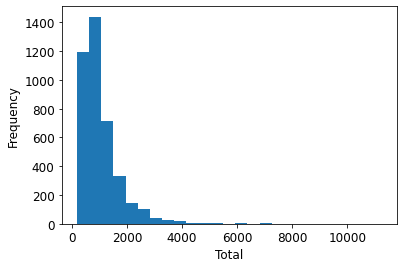

In [28]:
# Draw a histogram for "total"

%matplotlib inline
df3_pd['total'].hist(bins=25, grid=False, xlabelsize=12, ylabelsize=12)
plt.xlabel("Total", fontsize=12)
plt.ylabel("Frequency",fontsize=12)

In [29]:
# Save the dataframe in a .csv file

df3_pd.to_csv("C:\\Data Science\\Certifications\\AnalytixLabs\\Big Data-Hadoop-Spark\\Class 19-20 Files\\Spark Case Studies - Assignments\\App Analytics\Data\\df3_pd.csv")

#### 4. Behavior of purchasing and non-purchasing customers [something along the lines of their in-app event frequency in a given install-uninstall cycle]

In [30]:
# Purchasing customer events

df3 = sc.sql("select * from eventdump \
             where event in ('Checkout is completed by Cash On Delivery','Checkout is completed by Credit Cards / Debit Cards / Net Banking','Checkout is completed by null','Checkout is completed by Paid using zCoins','Checkout is completed by PG')")
df3.show(10)
df3.registerTempTable("df3")

# Non-purchasing customer events
df4 = sc.sql("select * from eventdump \
             where event not in ('Checkout is completed by Cash On Delivery','Checkout is completed by Credit Cards / Debit Cards / Net Banking','Checkout is completed by null','Checkout is completed by Paid using zCoins','Checkout is completed by PG')")
df4.show(10)
df4.registerTempTable("df4")

+----------------+--------------------+---------------+--------------------+
|            uuid|               event|event_timestamp|          properties|
+----------------+--------------------+---------------+--------------------+
|43e1796c34ac2a91|Checkout is compl...|        52:59.1|{'orderId': '6007...|
| a9dda7a3e84389f|Checkout is compl...|        33:24.5|{'orderId': '6007...|
|24fdb36b8483f66a|Checkout is compl...|        34:00.5|{'orderId': '6007...|
|1ab1d302727b542f|Checkout is compl...|        56:59.9|{'orderId': '6007...|
|fd7f809337907ced|Checkout is compl...|        36:08.4|{'orderId': '6007...|
|261b15b240aa3bdf|Checkout is compl...|        31:40.2|{'orderId': '6007...|
|69b818d976e1ff74|Checkout is compl...|        22:18.3|{'orderId': '6007...|
|152e3a56db1014ef|Checkout is compl...|        23:29.9|{'orderId': '6007...|
|d263954ca098c88d|Checkout is compl...|        46:46.8|{'orderId': '6007...|
|8bbffd7ca6ba15ec|Checkout is compl...|        11:45.9|{'orderId': '6007...|

In [31]:
# Join the df3 datarame with uicycles df2 dataframe
# Install-Uninstall Cycle for purchasing customers

df5 = sc.sql("select df3.event,df2.event_sequence, df2.cycle from df3 join df2 on df3.uuid = df2.uuid")
df5.show(5)
df5.registerTempTable("df5")

df7 = sc.sql("select event,event_sequence, sum(cycle) as total_cycle from df5 group by event,event_sequence")
df7.show(5)

+--------------------+--------------+-----+
|               event|event_sequence|cycle|
+--------------------+--------------+-----+
|Checkout is compl...|       install|  0.0|
|Checkout is compl...|       install|  0.0|
|Checkout is compl...|       install|  0.0|
|Checkout is compl...|       install|  0.0|
|Checkout is compl...|       install|  0.0|
+--------------------+--------------+-----+
only showing top 5 rows

+--------------------+--------------------+-----------+
|               event|      event_sequence|total_cycle|
+--------------------+--------------------+-----------+
|Checkout is compl...|uninstall#re-install|       15.0|
|Checkout is compl...|uninstall#re-inst...|        4.0|
|Checkout is compl...|install#uninstall...|        3.0|
|Checkout is compl...|install#re-instal...|        4.0|
|Checkout is compl...|install#re-instal...|       24.0|
+--------------------+--------------------+-----------+
only showing top 5 rows



In [32]:
# Join the df4 datarame with uicycles df2 dataframe
# Install-Uninstall Cycle for non-purchasing customers

df6 = sc.sql("select df4.event,df2.event_sequence, df2.cycle from df4 join df2 on df4.uuid = df2.uuid")
df6.show(5)
df6.registerTempTable("df6")

df8 = sc.sql("select event,event_sequence, sum(cycle) as total_cycle from df6 group by event,event_sequence")
df8.show(5)

+-------------------+-----------------+-----+
|              event|   event_sequence|cycle|
+-------------------+-----------------+-----+
|     Cart is viewed|          install|  0.0|
|Search is initiated|uninstall#install|  1.0|
|     Cart is viewed|          install|  0.0|
|     Cart is viewed|          install|  0.0|
|     Cart is viewed|          install|  0.0|
+-------------------+-----------------+-----+
only showing top 5 rows

+--------------------+--------------------+-----------+
|               event|      event_sequence|total_cycle|
+--------------------+--------------------+-----------+
|Push notification...|re-install#uninstall|       10.0|
|Search results pa...|uninstall#re-inst...|       15.0|
|     Login initiated|re-install#instal...|      100.0|
|  Push Event Clicked|uninstall#re-inst...|        6.0|
|     Login initiated|install#uninstall...|       12.0|
+--------------------+--------------------+-----------+
only showing top 5 rows



#### 5.Week over Week revenue trends for purchasing customers

In [33]:
# Extract the purchase date from the properties column
# Define a function that will parse the "total" field from the properties column

def json_timeStamp(stg): 
    stg = stg.replace("'", '"') # since json format needs double quotes in the string
    y = json.loads(stg)
#    print(y)
    return(y['timeStamp'])

# test with a sample string from properties column
stg = "{'orderId': '600731657', 'timeStamp': '25-08-2016 10:28:02', 'ts': '25-08-2016 10:28:02', 'shipping': 0.0, 'discount': 0.0, 'No Of Products': 6, 'payment_mode': 'Cash On Delivery', 'total': 4500, 'subtotal': 4475}"
#stg = '{"orderId": "600731657", "timeStamp": "25-08-2016 10:28:02", "ts": "25-08-2016 10:28:02", "shipping": 0.0, "discount": 0.0, "No Of Products": 6, "payment_mode": "Cash On Delivery", "total": 4500, "subtotal": 4475}'
json_timeStamp(stg) 

'25-08-2016 10:28:02'

In [34]:
df3_pd['timestamp'] = df3_pd['properties'].apply(json_timeStamp)
df3_pd['timestamp'] 

0       25-08-2016 10:28:02
1       26-08-2016 02:07:47
2       26-08-2016 09:15:27
3       26-08-2016 03:35:03
4       26-08-2016 03:10:12
               ...         
4043    30-08-2016 05:15:00
4044    31-08-2016 12:47:43
4045    31-08-2016 01:46:06
4046    31-08-2016 06:53:25
4047    31-08-2016 10:31:33
Name: timestamp, Length: 4048, dtype: object

In [35]:
# Save the updated df3_pd dataframe

df3_pd.to_csv("C:\\Data Science\\Certifications\\AnalytixLabs\\Big Data-Hadoop-Spark\\Class 19-20 Files\\Spark Case Studies - Assignments\\App Analytics\Data\\df3_pd.csv")

In [36]:
df3_pd.timestamp

import datetime

print ('Current date/time: {}'.format(datetime.datetime.now()))

Current date/time: 2020-08-17 21:46:50.857491


In [37]:
import datetime

date_time_str = '31-08-2016 06:53:25'
date_time_obj = datetime.datetime.strptime(date_time_str, '%d-%m-%Y %H:%M:%S')

print('Date:', date_time_obj.date())
print('Time:', date_time_obj.time())
print('Date-time:', date_time_obj)

Date: 2016-08-31
Time: 06:53:25
Date-time: 2016-08-31 06:53:25


In [38]:
def convert_to_date(str):
    date_time_str = str  # format should be '31-08-2016 06:53:25'
    date_time_obj = datetime.datetime.strptime(date_time_str, '%d-%m-%Y %H:%M:%S')
    x = date_time_obj.date()
    print(x)
    return(x)

In [39]:
# Convert from str object to date format
#convert_to_date("31-08-2016 06:53:25")

df3_pd['dt_timestamp'] = df3_pd['timestamp'].apply(convert_to_date)
df3_pd['dt_timestamp'].head(5)

2016-08-25
2016-08-26
2016-08-26
2016-08-26
2016-08-26
2016-08-26
2016-08-27
2016-08-27
2016-08-27
2016-08-27
2016-08-27
2016-08-27
2016-08-27
2016-08-27
2016-08-27
2016-08-28
2016-08-28
2016-08-28
2016-08-28
2016-08-28
2016-08-28
2016-08-28
2016-08-28
2016-08-28
2016-08-28
2016-08-28
2016-08-29
2016-08-29
2016-08-28
2016-08-29
2016-08-29
2016-08-29
2016-08-30
2016-08-30
2016-08-30
2016-08-30
2016-08-31
2016-08-31
2016-08-31
2016-08-31
2016-08-31
2016-08-31
2016-08-31
2016-08-25
2016-08-25
2016-08-25
2016-08-25
2016-08-25
2016-08-25
2016-08-26
2016-08-26
2016-08-26
2016-08-26
2016-08-26
2016-08-26
2016-08-27
2016-08-25
2016-08-27
2016-08-25
2016-08-27
2016-08-26
2016-08-27
2016-08-26
2016-08-27
2016-08-26
2016-08-28
2016-08-26
2016-08-28
2016-08-26
2016-08-28
2016-08-26
2016-08-28
2016-08-27
2016-08-28
2016-08-25
2016-08-27
2016-08-28
2016-08-27
2016-08-28
2016-08-27
2016-08-29
2016-08-27
2016-08-29
2016-08-27
2016-08-25
2016-08-29
2016-08-26
2016-08-27
2016-08-26
2016-08-29
2016-08-27

0    2016-08-25
1    2016-08-26
2    2016-08-26
3    2016-08-26
4    2016-08-26
Name: dt_timestamp, dtype: object

In [40]:
# Save the updated df3_pd dataframe

df3_pd.to_csv("C:\\Data Science\\Certifications\\AnalytixLabs\\Big Data-Hadoop-Spark\\Class 19-20 Files\\Spark Case Studies - Assignments\\App Analytics\Data\\df3_pd.csv")

In [41]:
# Convert data to week number

def convert_to_week(dt):
    return(dt.isocalendar()[1])

In [42]:
# Populate the week numbers for purchasing customers

df3_pd['week'] = df3_pd['dt_timestamp'].apply(convert_to_week)
df3_pd['week'].head(5)

0    34
1    34
2    34
3    34
4    34
Name: week, dtype: int64

In [43]:
# Save the updated df3_pd dataframe

df3_pd.to_csv("C:\\Data Science\\Certifications\\AnalytixLabs\\Big Data-Hadoop-Spark\\Class 19-20 Files\\Spark Case Studies - Assignments\\App Analytics\Data\\df3_pd.csv")

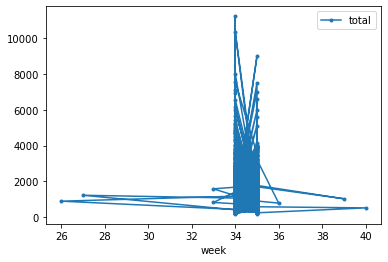

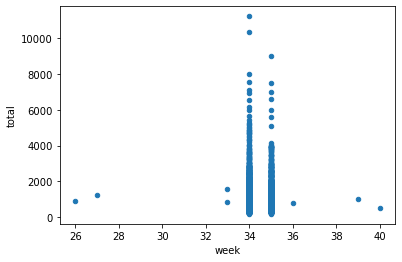

In [44]:
# Week-over-week change in total for purchasing customers

df3_pd.plot(x="week",y="total",marker='.')
df3_pd.plot(kind = 'scatter', x = 'week', y = 'total')


#### 6. How their purchases are distributed post install? [the number and value of purchases after installing the app in one retention cycle]

In [45]:
# Convert the df2 pyspark dataframe to pandas dataframe
# df2 has the event sequence and cycle information
# This is needed so we can join with the df3_pd in the next step

pd.set_option('display.max_colwidth', -1) # to view complete string in pandas
df2_pd = df2.select("*").toPandas()
df2_pd.head(4)

C:\Users\SESA475934\Anaconda3\envs\Python36\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


,uuid,event_sequence,cycle
0,10001b8438ddec6,install#uninstall,1.0
1,1068d33cc43241b8,install,0.0
2,1082f9be747d08c1,install,0.0
3,10921aeecf71f5b3,re-install,0.0


In [46]:
df3_pd.head(1)

,uuid,event,event_timestamp,properties,total,timestamp,dt_timestamp,week
0,43e1796c34ac2a91,Checkout is completed by Cash On Delivery,52:59.1,"{'orderId': '600731657', 'timeStamp': '25-08-2016 10:28:02', 'ts': '25-08-2016 10:28:02', 'shipping': 0.0, 'discount': 0.0, 'No Of Products': 6, 'payment_mode': 'Cash On Delivery', 'total': 4500, 'subtotal': 4475}",4500,25-08-2016 10:28:02,2016-08-25,34


In [47]:
# First convert the latest df3_pd to a spark dataframe
# Join the purchasing dataframe df8 with the uicycle dataframe df2 where retention cycle is 1

df8 = sc.createDataFrame(df3_pd)
df8.registerTempTable("df8")
df7 = sc.sql("select df8.*,df2.* from df8 join df2 on df8.uuid = df2.uuid where cycle =1")
df7.show(2)

+----------------+--------------------+---------------+--------------------+-----+-------------------+------------+----+----------------+-----------------+-----+
|            uuid|               event|event_timestamp|          properties|total|          timestamp|dt_timestamp|week|            uuid|   event_sequence|cycle|
+----------------+--------------------+---------------+--------------------+-----+-------------------+------------+----+----------------+-----------------+-----+
|3a2fd2dfd2b93846|Checkout is compl...|        28:28.8|{'orderId': '6007...|  668|28-08-2016 04:05:37|  2016-08-28|  34|3a2fd2dfd2b93846|uninstall#install|  1.0|
|b1cc91857160ff6d|Checkout is compl...|        49:56.0|{'orderId': '6007...| 1039|29-08-2016 05:28:14|  2016-08-29|  35|b1cc91857160ff6d|install#uninstall|  1.0|
+----------------+--------------------+---------------+--------------------+-----+-------------------+------------+----+----------------+-----------------+-----+
only showing top 2 rows



In [48]:
# Number of purchases and total value of purchases for 1 cycle

df9 = sc.sql("select event_sequence,sum(total) Total_Sales,count(*) Number_of_Purchases from df8 join df2 on df8.uuid = df2.uuid where cycle =1 group by event_sequence")
df9.show(10)

+--------------------+-----------+-------------------+
|      event_sequence|Total_Sales|Number_of_Purchases|
+--------------------+-----------+-------------------+
|uninstall#re-install|      25119|                 27|
|   install#uninstall|      40446|                 48|
|   uninstall#install|      35738|                 39|
|re-install#uninstall|      18575|                 23|
+--------------------+-----------+-------------------+



#### 7. Do they perform purchases in the 2nd, 3rd etc weeks post install? [if their retention cycle is greater than 1 week]

In [62]:
#Check the total sales of purchaing customers on a weekly basis.
# We will consider week 34 as week1 and week35 as week2
# So, for cycles >1 purchases are made on week2 

df10 = sc.sql("select case when week=34 then 'week1' when week=35 then 'week2' end Week, total Total_Sales from df8 join df2 on df8.uuid = df2.uuid where cycle >1 order by week")
df10.show(df10.count(), False)

+-----+-----------+
|Week |Total_Sales|
+-----+-----------+
|week1|877        |
|week1|1062       |
|week1|413        |
|week1|1039       |
|week1|1520       |
|week1|979        |
|week1|1233       |
|week1|2015       |
|week1|739        |
|week1|459        |
|week1|643        |
|week1|899        |
|week1|878        |
|week1|693        |
|week1|534        |
|week1|663        |
|week1|340        |
|week1|691        |
|week1|629        |
|week1|859        |
|week1|445        |
|week1|589        |
|week1|693        |
|week1|1812       |
|week1|1258       |
|week1|1043       |
|week1|313        |
|week1|889        |
|week1|958        |
|week1|926        |
|week1|1114       |
|week1|334        |
|week1|313        |
|week1|470        |
|week1|739        |
|week1|588        |
|week1|889        |
|week1|639        |
|week1|1128       |
|week1|643        |
|week1|639        |
|week1|668        |
|week1|510        |
|week1|668        |
|week1|313        |
|week1|1520       |
|week1|588        |


#### 7. Is there a steady inflow of revenue for customers with high retention? [Growth can decline but is it still a positive gradient?]

In [75]:
# Check the sales for high retention customers(cycle >2) on a date basis

df11 = sc.sql("select dt_timestamp,sum(total) Total_Sales from df8 join df2 on df8.uuid = df2.uuid where cycle >2 group by dt_timestamp order by dt_timestamp")
df11.show(20)

+------------+-----------+
|dt_timestamp|Total_Sales|
+------------+-----------+
|  2016-08-25|        668|
|  2016-08-26|       4194|
|  2016-08-27|       1388|
|  2016-08-28|       3038|
|  2016-08-30|       1719|
|  2016-08-31|       3185|
+------------+-----------+



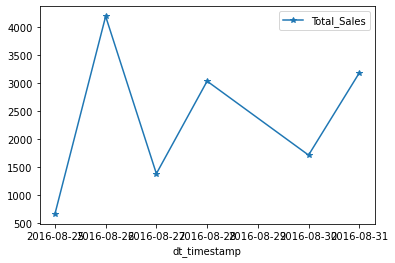

In [80]:
#Plot Sales against date for high retention cycle (>2)
#The graph is on a slightly upward trend, so we can say that there is a steady flow of income for high retention cycle

df11_pd=df11.toPandas()
df11_pd.plot(x="dt_timestamp",y="Total_Sales",marker='*')

#### 8. Any other actionable insights that can be drawn from the given data?

In [88]:
# Check which type of event gives maximum sales

df12 = sc.sql("select event, sum(total) Total_Sales from df8 join df2 on df8.uuid = df2.uuid where cycle > 1 group by event order by event")
df12.show(df12.count(), False)

# Check which customers have the maximum retention cycles

df13 = sc.sql("select df8.uuid, count(cycle) Retention_Cycle from df8 join df2 on df8.uuid = df2.uuid where cycle > 1 group by df8.uuid order by df8.uuid")
df13.show(df13.count(), False)

+-----------------------------------------------------------------+-----------+
|event                                                            |Total_Sales|
+-----------------------------------------------------------------+-----------+
|Checkout is completed by Cash On Delivery                        |55426      |
|Checkout is completed by Credit Cards / Debit Cards / Net Banking|20071      |
|Checkout is completed by Paid using zCoins                       |4422       |
+-----------------------------------------------------------------+-----------+

+----------------+---------------+
|uuid            |Retention_Cycle|
+----------------+---------------+
|12f93f4c5dab959e|1              |
|1af66193118789a5|1              |
|1bd3a096f17ead73|1              |
|1c3bc2141b49e851|1              |
|1e78e38f70b0d140|1              |
|20de1789b3cbd4be|1              |
|299ba7e5bf7d60f0|1              |
|29f1f26faa49a7de|1              |
|2ad05d58f2f80840|1              |
|2bb64a48e6814a99|1